# Taking a closer look at our data
So far we have the following data:
* Meteorological data for the first day of the fire: temperatures, wind, humidity
* Historical meteorlogical data: sum of precipitation and snow for the 6 months preceding to the fire
* Land cover category for wildfire location  

Are there any patterns we should be aware of?

In [1]:
# Libraries import
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import of the wildfires data
fires = pd.read_csv('../../data/cleaned/wildfires_all.csv')
fires.head(2)

,X,Y,ContainmentDateTime,ControlDateTime,DailyAcres,DiscoveryAcres,FireCause,FireDiscoveryDateTime,IncidentTypeCategory,IncidentTypeKind,...,InitialLongitude,IrwinID,LocalIncidentIdentifier,POOCounty,POODispatchCenterID,POOFips,POOState,UniqueFireIdentifier,total_acres,fire_id
0,-111.348611,33.195755,2020-07-23 05:29:59+00:00,2020-07-23 05:29:59+00:00,8.0,2.5,Human,2020-07-22 21:51:00+00:00,WF,FI,...,-111.348700,{951823FA-0B72-4295-87C8-E042D602324E},1450,Pinal,AZTDC,4021,US-AZ,2020-AZA3S-001450,10.5,0
1,-115.748812,40.617506,2020-08-03 23:00:00+00:00,2020-09-02 15:00:00+00:00,5985.9,5.0,Natural,2020-07-19 23:00:00+00:00,WF,FI,...,-115.719777,{91E0CBAB-A24E-4590-B6C6-2B4A46907E8A},10145,Elko,NVEIC,32007,US-NV,2020-NVECFX-010145,5990.9,1


### Looking at fire locations

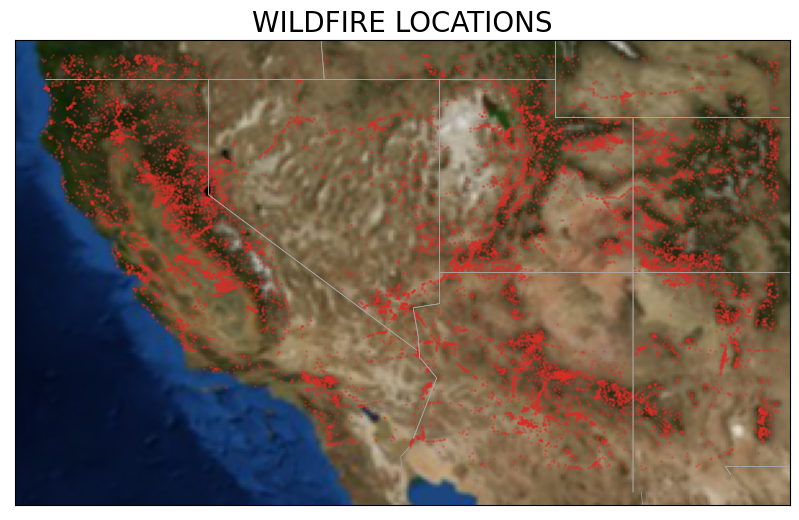

In [3]:
# Plotting a map in a default projection
plt.figure(figsize = (10,10));

m = Basemap(llcrnrlon=-125, llcrnrlat=31, urcrnrlon=-105, urcrnrlat=43) # extent setting
m.bluemarble() # background: satellite imagery

m.drawstates(linewidth=0.5, color = 'darkgrey') # US states boundaries

# Adding wildfires locations to a basemap
m.scatter(
    x=fires['X'], 
    y=fires['Y'], 
    alpha=0.3,
    marker = 'o',
    color = '#D62F29',
    s = 1
)

plt.title('WILDFIRE LOCATIONS', size = 20) # title

plt.savefig('../../public/visuals/wildfire_all_locations.png', dpi = 200, bbox_inches='tight'); # saving map

We've done some solid cleaning on wildfires dataset to narrow down the scope, so below are locations of fires that we ended up using for modeling.

In [4]:
# Import of the filtered wildfires data
fires_filtered = pd.read_csv('../../data/cleaned/wildfires_filtered.csv')

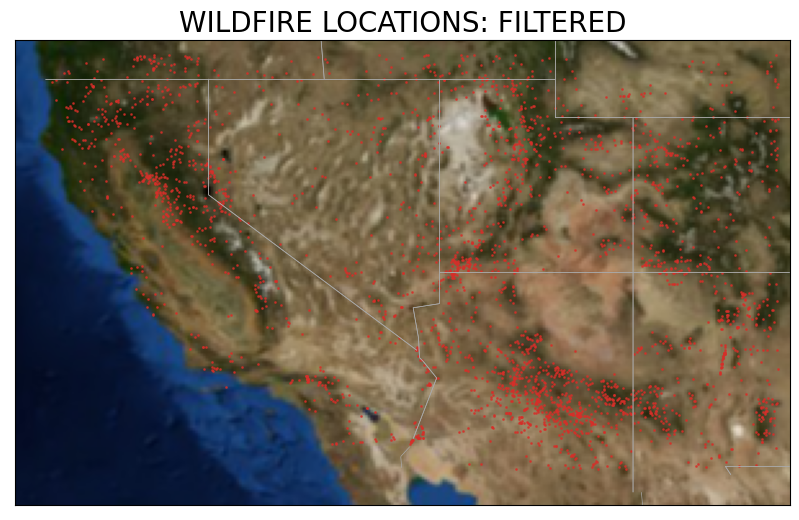

In [5]:
# Plotting a map in a default projection
plt.figure(figsize = (10,10));

m = Basemap(llcrnrlon=-125, llcrnrlat=31, urcrnrlon=-105, urcrnrlat=43) # extent setting
m.bluemarble() # background: satellite imagery

m.drawstates(linewidth=0.5, color = 'darkgrey') # US states boundaries

# Adding wildfires locations to a basemap
m.scatter(
    x=fires_filtered['X'], 
    y=fires_filtered['Y'], 
    alpha=0.7,
    marker = 'o',
    color = '#D62F29',
    s = 1
)

plt.title('WILDFIRE LOCATIONS: FILTERED', size = 20) # title

plt.savefig('../../public/visuals/wildfire_filtered_locations.png', dpi = 200, bbox_inches='tight'); # saving map

### Looking at fires sizes, duration, and cause

In [6]:
# Converting datetime columns to a proper datetime format
fires['FireDiscoveryDateTime'] = pd.to_datetime(fires['FireDiscoveryDateTime'])
fires['ContainmentDateTime'] = pd.to_datetime(fires['ContainmentDateTime'])
fires['ControlDateTime'] = pd.to_datetime(fires['ControlDateTime'])

## Creating duration in days column
fires['duration'] = fires['ControlDateTime'] - fires['FireDiscoveryDateTime']
fires['duration'] = fires['duration'].apply(lambda x: x.days)

# Calculating total acreage from discovery acres and daily acres
fires['total_acreage'] = fires['DiscoveryAcres'] + fires['DailyAcres']

In [7]:
# Merging 'Unknown' and 'Undetermined' fire cause into one category
fires['FireCause'] = fires['FireCause'].map(lambda i: 'Unknown' if i == 'Undetermined' else i)

In [8]:
fires['FireCause'].unique()

array(['Human', 'Natural', 'Unknown'], dtype=object)

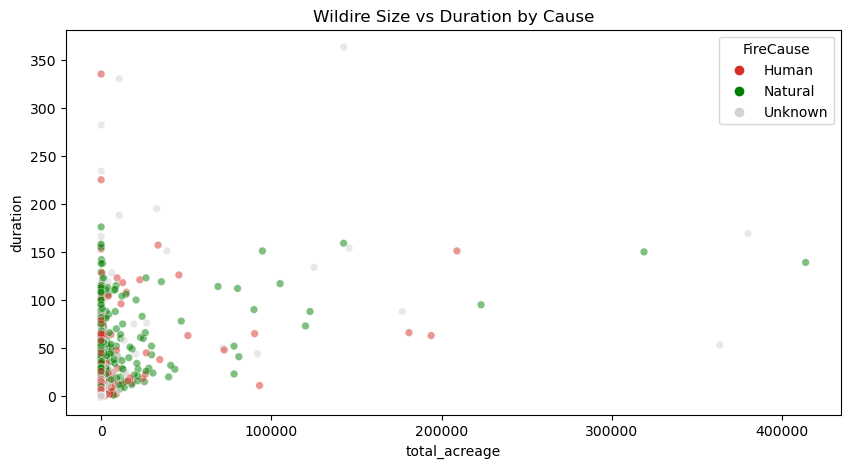

In [9]:
# Setting palette
palette = ['#D62F29','green','lightgrey']
# Plotting wildfires size, duration and cause
plt.figure(figsize = (10,5)) # figure size

sns.scatterplot( # plotting wildfires' size, duration, colored by cause
    data=fires,
    x='total_acreage',
    y='duration',
    marker = 'o',
    s = 30,
    hue='FireCause',
    palette = palette,
    alpha = 0.5,

)
plt.title('Wildire Size vs Duration by Cause');

From the scatterplot above, we can clearly see some outliers with enormous acreage burned. We will be removing them during the modeling. For now, I'm going to apply axes limits to look closer at the main part of wildfires' distribution.

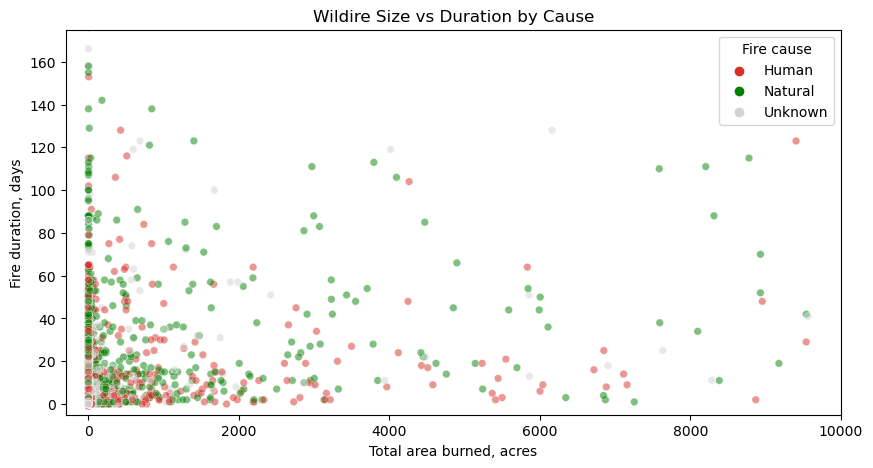

In [10]:
# Plotting wildfires size, duration and cause
plt.figure(figsize = (10,5)) # figure size

sns.scatterplot( # plotting wildfires' size, duration, colored by cause
    data=fires,
    x='total_acreage',
    y='duration',
    hue='FireCause',
    palette = palette,
    marker = 'o',
    alpha = 0.5,
    s = 30
)
# Limiting extent to remove outliers
plt.xlim(-300, 10000)
plt.ylim(-5, 175)

# Axes and plot titles
plt.xlabel('Total area burned, acres')
plt.ylabel('Fire duration, days')
plt.title('Wildire Size vs Duration by Cause')
plt.legend(loc='upper right', title = 'Fire cause')

plt.savefig('../../public/visuals/wildfire_all_size_vs_duration.png', dpi = 200);

It's hard to tell any patterns from the plot above except the fact that wildfires from the data we got are very different by their nature. Is it different for filtered data?

In [11]:
# Repeating the columns creation for fires_filtered dataset
fires_filtered['FireDiscoveryDateTime'] = pd.to_datetime(fires_filtered['FireDiscoveryDateTime'])
fires_filtered['ContainmentDateTime'] = pd.to_datetime(fires_filtered['ContainmentDateTime'])
fires_filtered['ControlDateTime'] = pd.to_datetime(fires_filtered['ControlDateTime'])

## Creating duration in days column
fires_filtered['duration'] = fires_filtered['ControlDateTime'] - fires_filtered['FireDiscoveryDateTime']
fires_filtered['duration'] = fires_filtered['duration'].apply(lambda x: x.days)

# Calculating total acreage from discovery acres and daily acres
fires_filtered['total_acreage'] = fires_filtered['DiscoveryAcres'] + fires_filtered['DailyAcres']

# Merging 'Unknown' and 'Undetermined' fire cause into one category
fires_filtered['FireCause'] = fires_filtered['FireCause'].map(lambda i: 'Unknown' if i == 'Undetermined' else i)

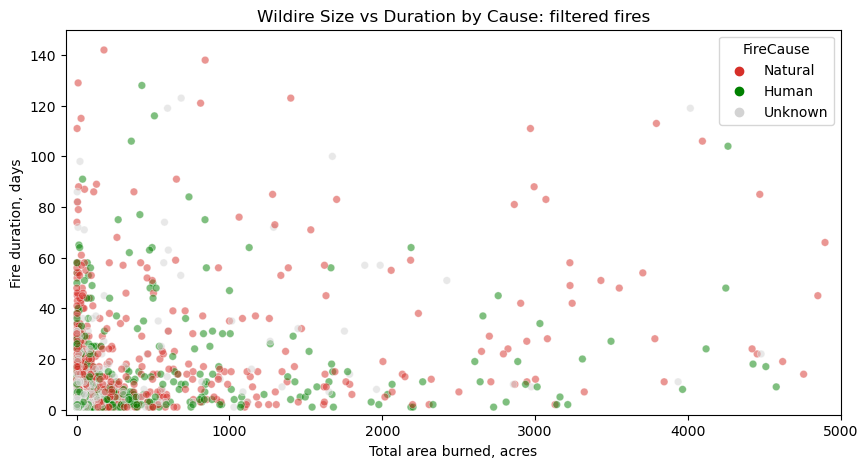

In [12]:
# Plotting FILTERED wildfires size, duration and cause
plt.figure(figsize = (10,5)) # figure size

sns.scatterplot( # plotting wildfires' size, duration, colored by cause
    data=fires_filtered,
    x='total_acreage',
    y='duration',
    hue='FireCause',
    palette = palette,
    marker = 'o',
    alpha = 0.5,
    s = 30
)
# Limiting extent to remove outliers
plt.xlim(-70, 5000)
plt.ylim(-2, 150)

# Axes and plot titles
plt.xlabel('Total area burned, acres')
plt.ylabel('Fire duration, days')
plt.title('Wildire Size vs Duration by Cause: filtered fires')

plt.savefig('../../public/visuals/wildfire_filtered_size_vs_duration.png', dpi = 200);

Nothing changed in patterns - there's still no correlation between cause, size and duration for even 'non-tiny' fires.

### Link between area burned and pre-fire season precipitation and snowpack

In [13]:
# Extracting date from datetime Discovery
fires_filtered['date'] = fires_filtered['FireDiscoveryDateTime'].apply(lambda x: x.date())
# Getting year_month column
fires_filtered['year_month'] = fires_filtered['date'].apply(lambda x: str(x.year) + '_' + str(x.month) if len(str(x.month)) == 2 else str(x.year) + '_0' + str(x.month))

In [14]:
# Summing up acres burned by year_month
fires_sum = pd.DataFrame(fires_filtered.groupby(by = 'year_month')['total_acres'].sum())

In [15]:
fires_sum.head()

,total_acres
year_month,
2020_01,21.10
2020_02,710.15
2020_03,330.91
2020_04,2810.04
2020_05,103050.60


In [16]:
# Adding historical precipitation for all locations we queried and transforming them to time series
rain = pd.read_csv('../../data/raw/meteorology_nasa_weather_last_180days.csv')
rain = rain[rain.PARAMETER == 'PRECTOTCORR_SUM'] # filtering to rain only
rain = rain.drop(columns = ['PARAMETER', 'ANN','PID']) # removing extra columns
rain = rain.groupby(by = 'YEAR').sum() # summing up rain amount throughout all locations together
rain.columns = ['01','02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'] # renaming months to their numbers

In [17]:
rain

,01,02,03,04,05,06,07,08,09,10,11,12
YEAR,,,,,,,,,,,,
2019,20207.51,39682.41,20787.69,9101.39,16120.86,3401.23,7234.63,5299.61,13573.76,1882.41,28988.21,21568.24
2020,36296.26,41120.63,89606.06,26044.37,18582.39,18709.87,22807.00,8557.62,9765.24,9043.67,28827.33,30496.68
2021,33301.42,18831.19,19331.62,9386.01,9299.97,10370.84,52237.20,34645.58,25112.59,42797.30,10844.43,67862.11


In [18]:
rain_sum = rain.melt() # flattenning table by year
rain_sum['year'] = ['2019', '2020', '2021']*12 # reassigning years back
rain_sum.columns = ['year_month', 'rain', 'year'] # renaming columns
rain_sum['year_month'] = rain_sum['year'].astype(str) + '_' + rain_sum['year_month'] # adding year and month together
rain_sum = rain_sum.sort_values(by = 'year_month') # sorting data chronologically
rain_sum = rain_sum.drop(columns = 'year') # got rid of the year

In [19]:
rain_sum.head()

,year_month,rain
0,2019_01,20207.51
3,2019_02,39682.41
6,2019_03,20787.69
9,2019_04,9101.39
12,2019_05,16120.86


In [20]:
# Doing the same for snow
snow = pd.read_csv('../../data/raw/meteorology_nasa_weather_last_180days.csv')
snow = snow[snow.PARAMETER == 'PRECSNO'] # filtering to snow only
snow = snow.drop(columns = ['PARAMETER', 'ANN','PID']) # removing extra columns
snow = snow.groupby(by = 'YEAR').sum() # summing up snow amount throughout all locations together
snow.columns = ['01','02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'] # renaming months to their numbers
snow_sum = snow.melt() # flattenning table by year
snow_sum['year'] = ['2019', '2020', '2021']*12 # reassigning years back
snow_sum.columns = ['year_month', 'snow', 'year'] # renaming columns
snow_sum['year_month'] = snow_sum['year'].astype(str) + '_' + snow_sum['year_month'] # adding year and month together
snow_sum = snow_sum.sort_values(by = 'year_month') # sorting data chronologically
snow_sum = snow_sum.drop(columns = 'year') # got rid of the year

In [21]:
# Concatenating rain and snow
rain_snow = pd.concat([rain_sum, snow_sum['snow']], axis = 1)

In [22]:
rain_snow.head()

,year_month,rain,snow
0,2019_01,20207.51,337.90
3,2019_02,39682.41,713.16
6,2019_03,20787.69,296.28
9,2019_04,9101.39,71.94
12,2019_05,16120.86,72.60


In [23]:
# Putting it all together
rain_snow = rain_snow.merge(fires_sum, how = 'left', left_on = 'year_month', right_on = 'year_month') # merging acreage burned with snow and rain data

In [24]:
rain_snow = rain_snow.iloc[6:] # slicing dataframe so it starts from summer 2019

In [25]:
rain_snow.tail()

,year_month,rain,snow,total_acres
31,2021_08,34645.58,0.60,197800.36
32,2021_09,25112.59,1.60,182968.11
33,2021_10,42797.30,183.47,18264.05
34,2021_11,10844.43,76.83,327.31
35,2021_12,67862.11,1557.32,141.60


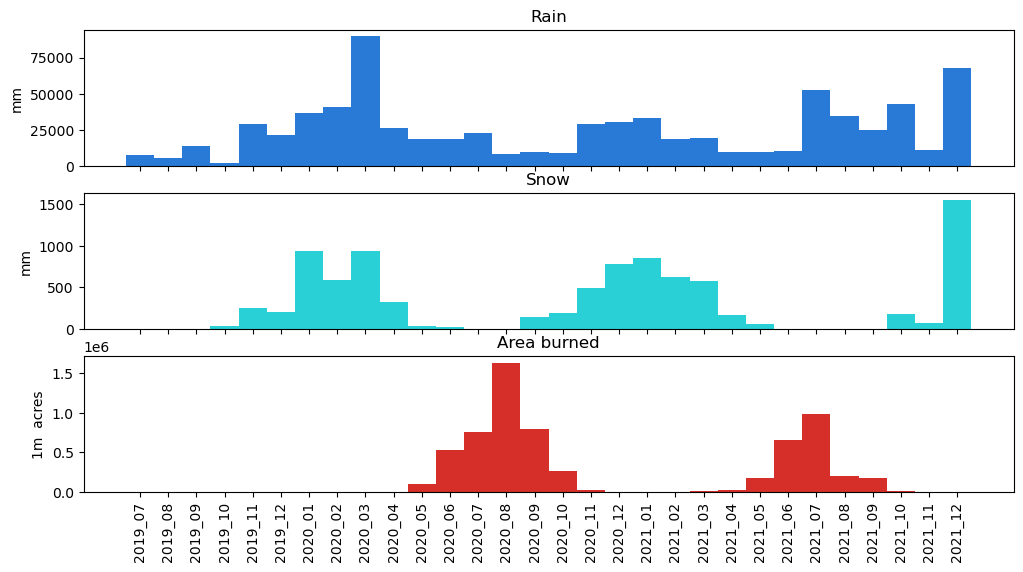

In [26]:
# Plotting rain, snow and burned area sums by months to show seasonality
fig, ax = plt.subplots(nrows = 3, sharex = True, figsize = (12, 6))

# Rain
ax[0].bar(rain_snow.year_month, rain_snow.rain, width = 1, color = '#297AD6')
ax[0].set_title('Rain')
ax[0].set_ylabel('mm')

# Snow
ax[1].bar(rain_snow.year_month, rain_snow.snow, width = 1, color = '#29D0D6')
ax[1].set_title('Snow')
ax[1].set_ylabel('mm')

# Acres burned
ax[2].bar(rain_snow.year_month, rain_snow.total_acres, width = 1, color = '#D62F29')
ax[2].set_title('Area burned')
ax[2].set_ylabel('1m  acres')

plt.xticks(rotation = 90); # labels rotation

plt.savefig('../../public/visuals/fire_rain_snow.png', dpi = 200, pad_inches=0.5, bbox_inches='tight'); # saving plot

Subplots above show two patterns in the same time - link between current meteorological conditions wirh area burned, and how pre-fire season precipitation is connected to the acreage affected by fires during the summer.
### Land cover EDA
Let's look at which vegetation types are affected by wildfires most.

In [27]:
# Import of land cover attributes table
attrs = pd.read_excel('../../data/raw/land_cover_attributes.xlsx', skiprows = [1]) # skipping first row because it's a sum count
attrs.head(3)

,Value,Count,RED,GREEN,BLUE,CL,NVC_CLASS,SC,NVC_SUBCL,FRM,NVC_FORM,DIV,NVC_DIV,MACRO_CD,NVC_MACRO,GR,NVC_GROUP,LEVEL3,ECOLSYS_LU,NVCMES
0,1,382166,0.0,0.51765,0.4902,1,Forest & Woodland,1.A,Tropical Forest & Woodland,1.A.4,Tropical Flooded & Swamp Forest,1.A.4.Ed,Caribbean-Central American Flooded & Swamp Forest,M617,Caribbean Swamp,G002,Caribbean Lowland Swamp,9238,South Florida Bayhead Swamp,1.A.4.Ed M617G002E1
1,2,976706,0.0,0.51765,0.4902,1,Forest & Woodland,1.A,Tropical Forest & Woodland,1.A.4,Tropical Flooded & Swamp Forest,1.A.4.Ed,Caribbean-Central American Flooded & Swamp Forest,M617,Caribbean Swamp,G002,Caribbean Lowland Swamp,9702,South Florida Cypress Dome,1.A.4.Ed M617G002E2
2,3,726902,0.0,0.51765,0.4902,1,Forest & Woodland,1.A,Tropical Forest & Woodland,1.A.4,Tropical Flooded & Swamp Forest,1.A.4.Ed,Caribbean-Central American Flooded & Swamp Forest,M617,Caribbean Swamp,G002,Caribbean Lowland Swamp,9305,South Florida Dwarf Cypress Savanna,1.A.4.Ed M617G002E3


In [39]:
attrs.dtypes

Value           int64
Count           int64
RED           float64
GREEN         float64
BLUE          float64
CL              int64
NVC_CLASS      object
SC             object
NVC_SUBCL      object
FRM            object
NVC_FORM       object
DIV            object
NVC_DIV        object
MACRO_CD       object
NVC_MACRO      object
GR             object
NVC_GROUP      object
LEVEL3          int64
ECOLSYS_LU     object
NVCMES         object
dtype: object

In [28]:
# Adding fires data with vegetation zone listed
fires = pd.read_csv('../../data/processed/master_dataset_allfires.csv')
fires['landcover_class'] = fires['landcover_class'] + 1 # fixing shifted id due to QGIS preprocessing

In [29]:
fires.landcover_class.describe()

count    20276.000000
mean       331.965476
std        182.605131
min          1.000000
25%        163.000000
50%        305.000000
75%        490.000000
max        585.000000
Name: landcover_class, dtype: float64

In [30]:
# Calculating acreage burned by land cover type
burned = pd.DataFrame(fires.groupby(by = 'landcover_class')['total_acres'].sum())

In [31]:
# Merging calculated acreage burned with master attribute table
burned = burned.merge(attrs, how = 'left', left_on = 'landcover_class', right_on = 'Value')

In [32]:
burned.head(3)

,total_acres,Value,Count,RED,GREEN,BLUE,CL,NVC_CLASS,SC,NVC_SUBCL,...,NVC_FORM,DIV,NVC_DIV,MACRO_CD,NVC_MACRO,GR,NVC_GROUP,LEVEL3,ECOLSYS_LU,NVCMES
0,409.77,1.0,382166.0,0.00000,0.51765,0.49020,1.0,Forest & Woodland,1.A,Tropical Forest & Woodland,...,Tropical Flooded & Swamp Forest,1.A.4.Ed,Caribbean-Central American Flooded & Swamp Forest,M617,Caribbean Swamp,G002,Caribbean Lowland Swamp,9238.0,South Florida Bayhead Swamp,1.A.4.Ed M617G002E1
1,6411.42,40.0,390651.0,0.12157,0.61176,0.36078,1.0,Forest & Woodland,1.B,Temperate & Boreal Forest & Woodland,...,Warm Temperate Forest & Woodland,1.B.1.Nc,Californian Warm Temperate Forest & Woodland,M009,Californian Forest & Woodland,G198,Californian Conifer Forest & Woodland,4545.0,California Coastal Closed-Cone Conifer Forest ...,1.B.1.NcM009G198E40
2,1.22,41.0,4967451.0,0.12157,0.61176,0.36078,1.0,Forest & Woodland,1.B,Temperate & Boreal Forest & Woodland,...,Warm Temperate Forest & Woodland,1.B.1.Nc,Californian Warm Temperate Forest & Woodland,M009,Californian Forest & Woodland,G195,Californian Broadleaf Forest & Woodland,5502.0,California Coastal Live Oak Woodland and Savanna,1.B.1.NcM009G195E41


In [33]:
# Sorting dataset
burned = burned.sort_values(by = 'total_acres', ascending = False)

In [34]:
# Manually setting labels formatting
labels = []
for i in burned.ECOLSYS_LU.iloc[:10]:
    print(i)
    labels.append(i)

Inter-Mountain Basins Big Sagebrush Steppe
California Montane Jeffrey Pine-(Ponderosa Pine) Woodland
Sonoran Mid-Elevation Desert Scrub
Mediterranean California Mesic Mixed Conifer Forest and Woodland
Colorado Plateau Mixed Low Sagebrush Shrubland
Developed, Medium Intensity
Rocky Mountain Poor-Site Lodgepole Pine Forest
Southern Rocky Mountain Juniper Woodland and Savanna
Inter-Mountain Basins Montane Sagebrush Steppe
Mediterranean California Subalpine Woodland


In [35]:
# Saving acreage and zone name for plotting
burned_1 = burned[['total_acres', 'ECOLSYS_LU','NVC_CLASS']][:10]

In [36]:
burned_1.reset_index(inplace = True)

In [37]:
# Adding line breaks to x labels
labels = ['Inter-Mountain \n Basins Big \n Sagebrush \nSteppe',
 'California Montane \n Jeffrey Pine-\n(Ponderosa Pine)\n Woodland',
 'Sonoran \nMid-Elevation \nDesert Scrub',
 'Mediterranean \nCalifornia \nMesic Mixed\n Conifer Forest\n and Woodland',
 'Colorado \nPlateau Mixed\n Low Sagebrush\n Shrubland',
 'Developed, \nMedium Intensity',
 'Rocky Mountain \nPoor-Site \nLodgepole \nPine Forest',
 'Southern Rocky\n Mountain \nJuniper \nWoodland \nand Savanna',
 'Inter-Mountain\n Basins Montane\n Sagebrush Steppe',
 'Mediterranean \nCalifornia \nSubalpine \nWoodland']

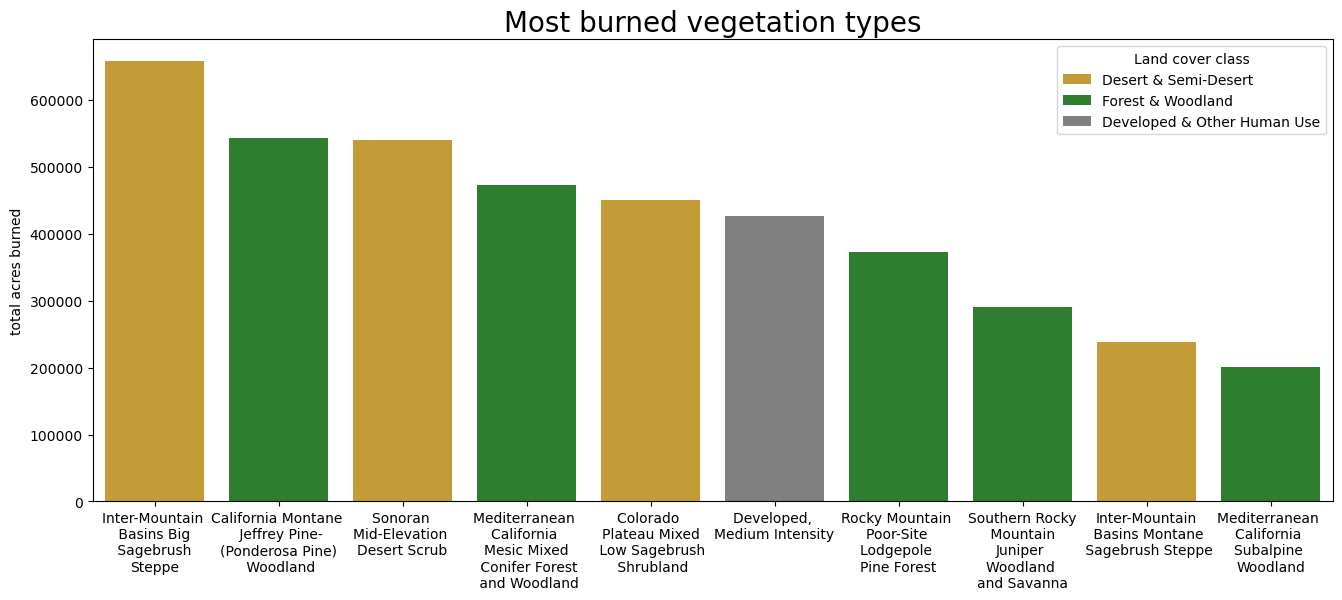

In [38]:
# Barplot of most burned categories 
plt.figure(figsize = (16,6))
sns.barplot(data=burned_1, x=burned_1.index, y='total_acres', hue = 'NVC_CLASS',dodge = False, palette = ['goldenrod','forestgreen','grey'])
plt.title('Most burned vegetation types', size = 20)
plt.xticks(burned_1.index, labels)
plt.xlabel('')
plt.legend(title = 'Land cover class', loc='upper right')
plt.ylabel('total acres burned')
plt.savefig('../../public/visuals/landcover_most_burned.png', dpi = 200, bbox_inches='tight'); # saving plot

To the contrary to the popular belief, desert ans semi-desert area suffer simialar to the forest areas from the wildfires.